# ASSIGNMENT 2

Link to the github repo - https://github.com/manya16400/CS-6980-Computer-Vision/tree/main/Assignment%201

# 1. Record video

In [3]:
import depthai as dai

# Create pipeline
pipeline = dai.Pipeline()

# Define sources and output
camRgb = pipeline.create(dai.node.ColorCamera)
videoEnc = pipeline.create(dai.node.VideoEncoder)
xout = pipeline.create(dai.node.XLinkOut)

xout.setStreamName('h265')

# Properties
camRgb.setBoardSocket(dai.CameraBoardSocket.RGB)
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_4_K)
videoEnc.setDefaultProfilePreset(30, dai.VideoEncoderProperties.Profile.H265_MAIN)

# Linking
camRgb.video.link(videoEnc.input)
videoEnc.bitstream.link(xout.input)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    # Output queue will be used to get the encoded data from the output defined above
    q = device.getOutputQueue(name="h265", maxSize=30, blocking=True)

    # The .h265 file is a raw stream file (not playable yet)
    with open('video.h265', 'wb') as videoFile:
        print("Press Ctrl+C to stop encoding...")
        try:
            while True:
                h265Packet = q.get()  # Blocking call, will wait until a new data has arrived
                h265Packet.getData().tofile(videoFile)  # Appends the packet data to the opened file
        except KeyboardInterrupt:
            # Keyboard interrupt (Ctrl + C) detected
            pass

    print("To view the encoded data, convert the stream file (.h265) into a video file (.mp4) using a command below:")
    print("ffmpeg -framerate 30 -i video.h265 -c copy video.mp4")

Press Ctrl+C to stop encoding...
To view the encoded data, convert the stream file (.h265) into a video file (.mp4) using a command below:
ffmpeg -framerate 30 -i video.h265 -c copy video.mp4


In [4]:
import ffmpeg

try:
    ffmpeg.input('video.h265')\
    .filter('fps', fps=30, round='up')\
    .output('out3.mkv', vcodec='libx265')\
    .run(capture_stdout=True, capture_stderr=True)
    
except ffmpeg.Error as e:
    print('stdout:', e.stdout.decode('utf8'))
    print('stderr:', e.stderr.decode('utf8'))
    raise e

## a.

In [58]:
# create a folder to store extracted images
import os

folder = 'extracted_img_frames'
#os.mkdir(folder)
# use opencv to do the job
import cv2
print(cv2.__version__)  # my version is 3.1.0
vidcap = cv2.VideoCapture('out3.mkv')
count = 0
while True:
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
    success,image = vidcap.read()
    print ('Read a new frame: ', success)
    if not success:
        break
    cv2.imwrite(os.path.join(folder,"frame{:d}.jpg".format(count)), image)     # save frame as JPEG file
    count += 1
print("{} images are extacted in {}.".format(count,'extracted_img_frames/'))

4.5.1
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  False
8 images are extacted in extracted_img_frames/.


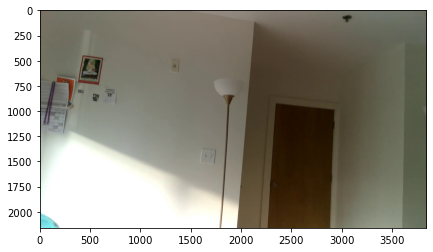

In [48]:
#img frame used for corner and edge detection

img = cv2.imread('extracted_img_frames/frame5.jpg')
plt.figure(figsize = (60,4))
plt.imshow(image[:,:,::-1])

## Harris corner detection

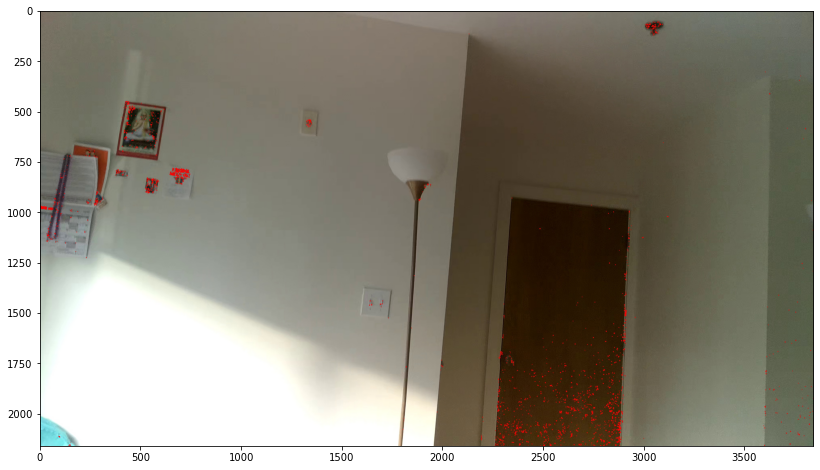

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
img = cv2.imread('extracted_img_frames/frame5.jpg')

gray = cv2.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

cv2.imwrite("cornerHarris.jpg", img)
res = cv2.imread('cornerHarris.jpg')

plt.figure(figsize = (60,8))
plt.imshow(res[:,:,::-1],cmap='gray')

## Canny edge detection

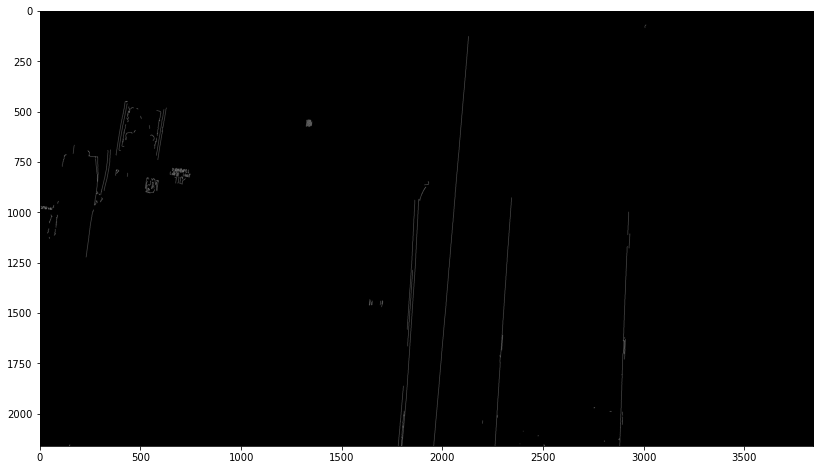

In [52]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('extracted_img_frames/frame5.jpg',0)
edges = cv.Canny(img,100,200)

cv2.imwrite("cannyEdge.jpg", edges)

res = cv2.imread('cannyEdge.jpg')

plt.figure(figsize = (60,8))
plt.imshow(res[:,:,::-1])
plt.show()

## b.

In [56]:
im_src = cv2.imread('extracted_img_frames/frame4.jpg')
# Four corners of the book in source image
pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]])

# Read destination image.
im_dst = cv2.imread('extracted_img_frames/frame5.jpg')
# Four corners of the book in destination image.
pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]])

# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

print(h)

[[ 4.34043935e-01 -4.19622184e-01  2.91709494e+02]
 [ 1.46491654e-01  4.41418278e-01  1.61369294e+02]
 [-3.62463336e-04 -9.14274844e-05  1.00000000e+00]]


# 2. Image Stitching

Matlab file - image_stitching.m

# 3. Integral Image Feed

In [23]:
mat = np.array([[17  ,  24  ,   1  ,  8  , 15],
       [23  ,   5  ,   7  , 14  , 16],
       [ 4  ,   6  ,  13  , 20  , 22],
       [10  ,  12  ,  19  , 21  ,  3],
       [11  ,  18  ,  25  ,  2  ,  9]])

mat[:2]

array([[17, 24,  1,  8, 15],
       [23,  5,  7, 14, 16]])

In [35]:
integral_mat = [[0 for i in range(len(mat[0])+1)] for j in range(len(mat)+1)]

integral_mat

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0]]

In [40]:
integral_mat = [[0 for i in range(len(mat[0])+1)] for j in range(len(mat)+1)]

for i in range(1,len(integral_mat)):
    for j in range(1,len(integral_mat[0])):
        #print(i,j)
        #print(mat[:i, :j])
        tmp = mat[:i, :j]
        s = 0
        for k in range(len(tmp)):
            for l in range(len(tmp[0])):
                s+=tmp[k][l]
                
        integral_mat[i][j] = s
        
integral_mat        

[[0, 0, 0, 0, 0, 0],
 [0, 17, 41, 42, 50, 65],
 [0, 40, 69, 77, 99, 130],
 [0, 44, 79, 100, 142, 195],
 [0, 54, 101, 141, 204, 260],
 [0, 65, 130, 195, 260, 325]]

In [59]:
def integral_image(image, *, dtype=None):
    if dtype is None and image.real.dtype.kind == 'f':
        dtype = np.promote_types(image.dtype, np.float64)

    S = image
    for i in range(image.ndim):
        S = S.cumsum(axis=i, dtype=dtype)
    return S


def integrate(ii, start, end):
    start = np.atleast_2d(np.array(start))
    end = np.atleast_2d(np.array(end))
    rows = start.shape[0]

    total_shape = ii.shape
    total_shape = np.tile(total_shape, [rows, 1])

    start_negatives = start < 0
    end_negatives = end < 0
    start = (start + total_shape) * start_negatives + \
             start * ~(start_negatives)
    end = (end + total_shape) * end_negatives + \
           end * ~(end_negatives)

    if np.any((end - start) < 0):
        raise IndexError('end coordinates must be greater or equal to start')

    S = np.zeros(rows)
    bit_perm = 2 ** ii.ndim
    width = len(bin(bit_perm - 1)[2:])
    for i in range(bit_perm):  
        binary = bin(i)[2:].zfill(width)
        bool_mask = [bit == '1' for bit in binary]

        sign = (-1)**sum(bool_mask)

        bad = [np.any(((start[r] - 1) * bool_mask) < 0)
               for r in range(rows)]  

        corner_points = (end * (np.invert(bool_mask))) + \
                         ((start - 1) * bool_mask)

        S += [sign * ii[tuple(corner_points[r])] if(not bad[r]) else 0
              for r in range(rows)]
    return S

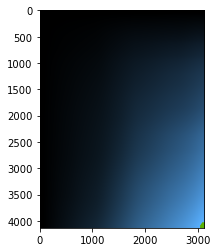

In [60]:
frame = cv2.imread('dahlberg1.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame= cv2.copyMakeBorder(frame, 50, 50, 50, 50, cv2.BORDER_CONSTANT, (0,0,0))
frame=integral_image(frame)
frame = frame/np.amax(frame)
frame = np.clip(frame, 0,255)
plt.imshow(frame)

# 4. Image Stitch using SIFT features

In [67]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt


class Image_Stitching():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.xfeatures2d.SIFT_create()
        self.smoothing_window_size=800

    def registration(self,img1,img2):
        #img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        #img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        #cv2.imwrite('matching.jpg', img3)
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result
    
def main(argv1,argv2):
    img1 = cv2.imread(argv1)
    img2 = cv2.imread(argv2)
    
    final = Image_Stitching().blending(img1,img2)
    cv2.imwrite('result-sift.jpg', final)
    plt.imshow(cv2.imread('result-sift.jpg')[:,:,::-1])
    plt.plot()
    

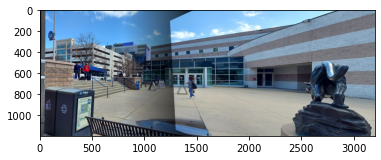

In [68]:
main('team3_Studentcenter_1.jpeg','team3_Studentcenter_2.jpeg')

# 5. Image Stitch using ORB features 

In [64]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt


class Image_Stitching():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.xfeatures2d.SIFT_create()
        self.orb=cv2.ORB_create()
        self.smoothing_window_size=800

    def registration(self,img1,img2):
        #img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        #img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        kp1, des1 = self.orb.detectAndCompute(img1, None)
        kp2, des2 = self.orb.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=False)
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        #cv2.imwrite('matching.jpg', img3)
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,4)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result
    
def main(argv1,argv2):
    img1 = cv2.imread(argv1)
    img2 = cv2.imread(argv2)
    
    final = Image_Stitching().blending(img1,img2)
    cv2.imwrite('result-orb.jpg', final)
    plt.imshow(cv2.imread('result-orb.jpg')[:,:,::-1])
    plt.plot()

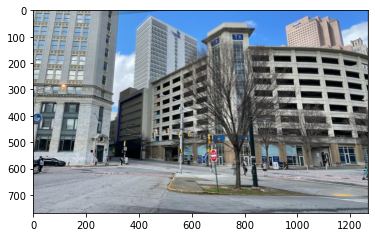

In [66]:
main('TDeck_team06_1.jpeg','TDeck_team06_2.jpeg')